In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from hurricane import *

# HURDAT2 Data
More information can be found here http://www.nhc.noaa.gov/data/hurdat/hurdat2-format-atlantic.pdf. This dataset contains storm & hurricane information for each storm by year. The following script downloads the latest file and performs some transformations. The HURDAT2 data contains multiple updates per storm. A series of "agg\_" columns are added which represent max values per storm.

Files are cached after the first processing and used if found.

In [2]:
# Update this file according to the latest from http://www.nhc.noaa.gov/data/hurdat/
df_hurricane = load_hurdat2_data(hurdat_file='hurdat2-1851-2016-041117.txt')

Reading cached HURDAT2


In [3]:
df_hurricane.columns

Index(['code', 'name', 'record_identifier', 'storm_status', 'latitude',
       'longitude', 'max_wind', 'min_pressure', 'wind_34kt_ne', 'wind_34kt_se',
       'wind_34kt_sw', 'wind_34kt_nw', 'wind_50kt_ne', 'wind_50kt_se',
       'wind_50kt_sw', 'wind_50kt_nw', 'wind_64kt_ne', 'wind_64kt_se',
       'wind_64kt_sw', 'wind_64kt_nw', 'datetime', 'year', 'month',
       'status_rank', 'status_cat', 'agg_max_wind', 'agg_wind_34kt_ne',
       'agg_wind_34kt_se', 'agg_wind_34kt_sw', 'agg_wind_34kt_nw',
       'agg_wind_50kt_ne', 'agg_wind_50kt_se', 'agg_wind_50kt_sw',
       'agg_wind_50kt_nw', 'agg_wind_64kt_ne', 'agg_wind_64kt_se',
       'agg_wind_64kt_sw', 'agg_wind_64kt_nw', 'agg_status_rank',
       'agg_status_cat', 'agg_min_pressure', 'agg_maxwind_34kt_tot',
       'agg_maxwind_50kt_tot', 'agg_maxwind_64kt_tot'],
      dtype='object')

In [4]:
df_hurricane.to_csv('hurricane_data.csv')

# ERSST Data
ERSST data is a global monthly dataset of sea surface temperatures. More information can be found here https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v3b. This script downloads multiple years and truncates the data to the bounding box specified below.

Files are cached as a single transformed dataframe once completed.

## Bounding Box
Bounding box is defined as a tuple of (top-left, bottom-right) data to keep. In this case the coordinates `(46,250), (0,360)` are specified. The 46 and 0 cover the Atlantic Ocean from the equator up north to around Maine. The coordinates 257, 360 transate to -102W to 0 or as far west as Colorado to the prime meridian. This box is defined to capture most of the ocean.

![Map](map.jpg)

In [5]:
'''
Specs based on: https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/ascii/Readme

latitude: -88.0, increase northward per 2 degree, to +88.0
longitude:  0.0, increase eastward per 2 degree, to 358.0

bounding_box: Defined as top-left, bottom-right
'''
bounding_box=((46, 257), (0, 360)) 
df_sst = load_ersst_data(year_start=1900, year_end=2016, bounding_box=bounding_box)

Reading cached ERSST. Warning: Parameters ignored.


In [6]:
df_sst.columns

Index([      0,       2,       4,       6,       8,      10,      12,      14,
            16,      18,      20,      22,      24,      26,      28,      30,
            32,      34,      36,      38,      40,      42,      44,      46,
        'year', 'month'],
      dtype='object')

# Get median yearly temperature
The ESSRT data is computed for a grid that is spaced by 2 degrees in N-S / W-E directions. The median temperature here is calculated by looking at every value that exists for a year. Values are indexed against 1900.

In [7]:
def get_median_sst(df):
    cols = [c for c in df.columns if c not in ['year','month']]
    
    median_temps = []
    for k,v in df.groupby('year'):
        reshaped = np.reshape(v[cols].values,(-1,))
        median_temps.append((k, np.nanmedian(reshaped)))
    
    df = pd.DataFrame(median_temps, columns=['year','median_change']).set_index('year')
    
    return df.sub(df.iloc[0,:])

df_sst_yearly = get_median_sst(df_sst)
df_sst_yearly.head(3)

,median_change
year,
1900,0.00
1901,-0.06
1902,-0.24


# Calculate yearly storms
We define Cat 4 or 5 storms as "H" while the remaining storms are "L". For each year, a rolling 3 year sum is also calculated since the data is a little noisy year to year. The percentage reprents the % of cat 4/5 storms for the 3 year period out of all hurricanes. This is joined back to the yearly change in sea temperatures.

In [11]:
def get_yearly_storms(data_hurricane, data_sst):
    
    df_agg = df_hurricane.copy()[(df_hurricane.agg_status_rank==8) & (df_hurricane.year>=1920)]
    
    def label(x):
        if x>=4:
            return 'H'
        else:
            return 'L'
        
    df_agg['agg_status_cat'] = df_agg['agg_status_cat'].apply(label) 
    
    df_agg = (
        df_agg.groupby('code')[['year','agg_status_cat']]
          .max()
          .reset_index()
          .groupby(['year','agg_status_cat'])
        .agg({'code': pd.Series.count})
        .reset_index()
           
         )

    df_agg = df_agg.pivot(index='year', columns='agg_status_cat', values='code').fillna(0)
    df_agg['HR'] = df_agg['H'].rolling(3).sum()
    df_agg['LR'] = df_agg['L'].rolling(3).sum()
    df_agg['PCT'] = df_agg['HR'] / (df_agg['HR'] + df_agg['LR'])
    df_agg = df_agg.merge(data_sst, left_index=True, right_index=True)
    
    return df_agg

yearly = get_yearly_storms(df_hurricane, df_sst_yearly)
yearly.head(5)

,H,L,HR,LR,PCT,median_change
year,,,,,,
1920,0.0,4.0,NaN,NaN,NaN,-0.490
1921,1.0,4.0,NaN,NaN,NaN,-0.290
1922,0.0,3.0,1.0,11.0,0.083333,-0.455
1923,0.0,4.0,1.0,11.0,0.083333,-0.530
1924,1.0,4.0,1.0,11.0,0.083333,-0.460


In [13]:
yearly.to_csv('yearly_events.csv')

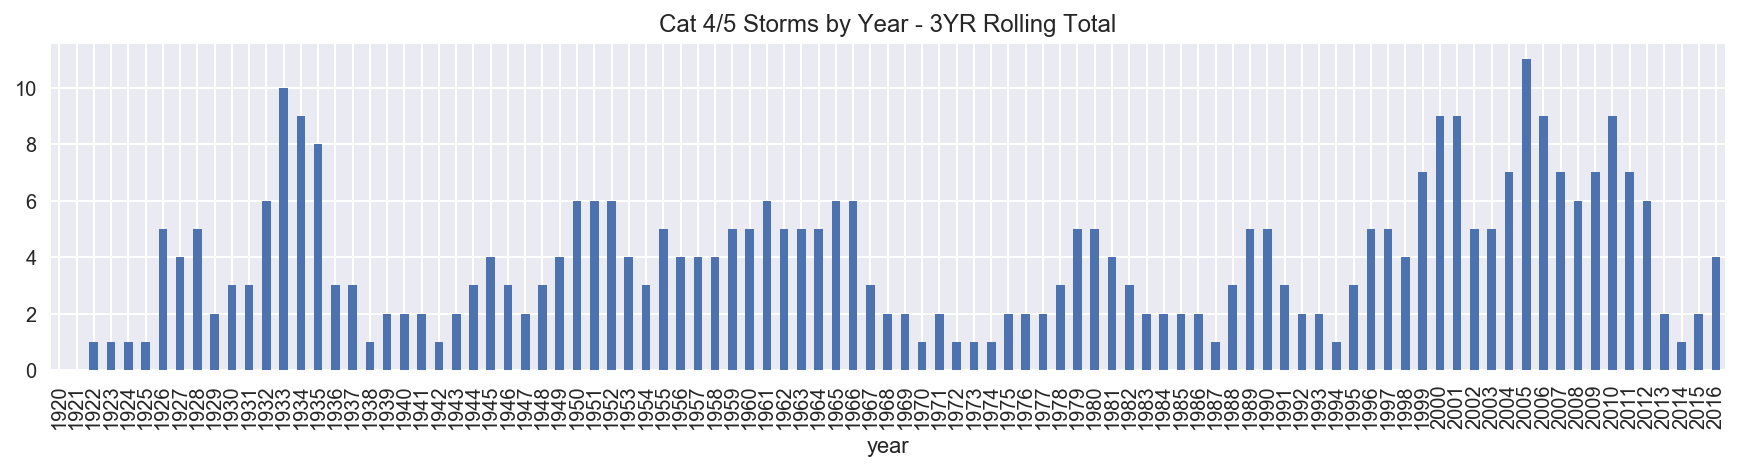

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

yearly['HR'].plot(kind='bar', figsize=(15,3), title='Cat 4/5 Storms by Year - 3YR Rolling Total');

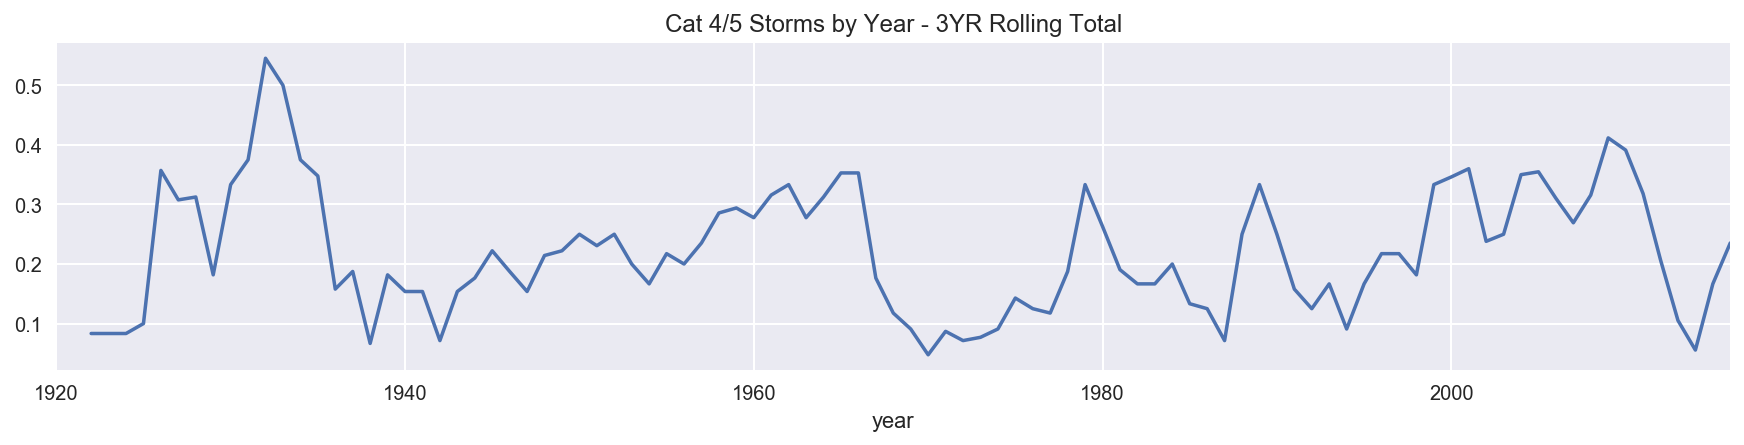

In [29]:
yearly['PCT'].plot(kind='line', figsize=(15,3), title='Cat 4/5 Storms by Year - 3YR Rolling Total');

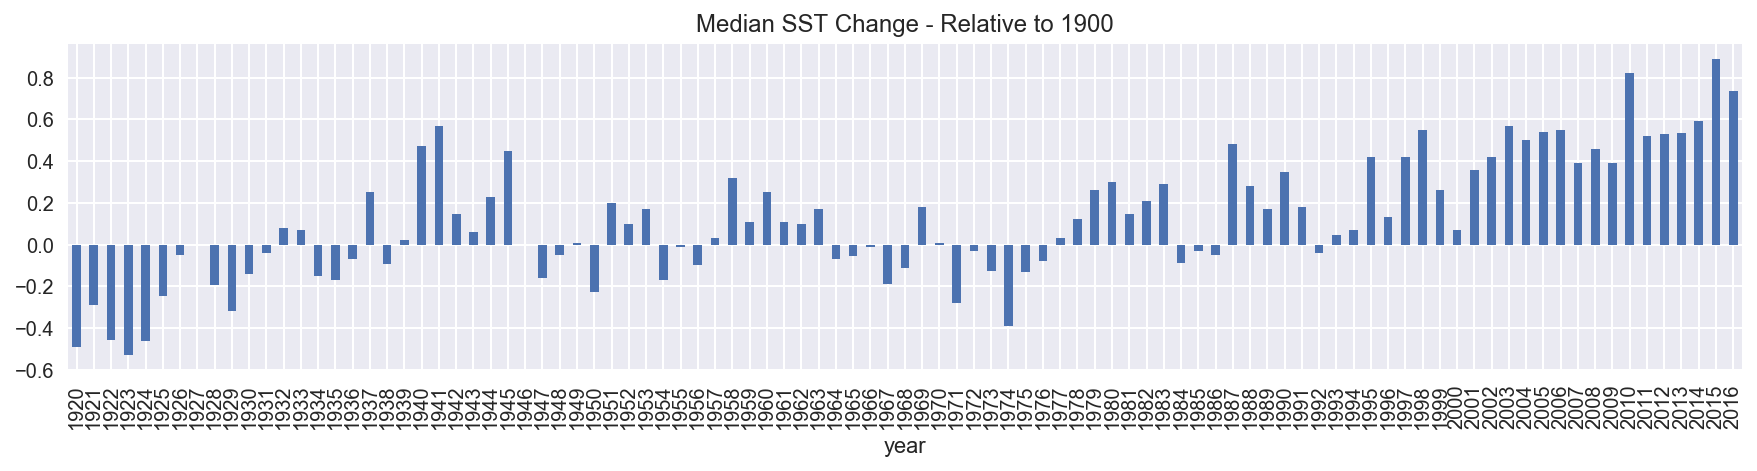

In [27]:
yearly['median_change'].plot(kind='bar', figsize=(15,3), title='Median SST Change - Relative to 1900');